## Imports

In [1]:
# File
import pathlib

In [2]:
# Data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import skew, skewtest

In [3]:
# Charting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Deep Learning
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, MaxPool1D, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Preprocessing functions

In [5]:
def walk_forward(df, x_labels, y_labels, n, n_input_labels, 
                 split_per=None, split_data=False, y_offset=0):
    
    td_shape = df.shape
    td_l = td_shape[0]
    
    x_indices = [range(i, i+n) for i in range(td_l-n)]
    y_indices = [range(i+y_offset, i+n) for i in range(td_l-n)]
    
    x = df.loc[:, x_labels].values[x_indices]
    y = df.loc[:, y_labels].values[y_indices]
    
    if split_data:
        split_index = int(len(x)*split_per)
        x = x.reshape(-1, n, n_input_labels, 1)
        y = y.reshape(-1, n-y_offset)
        X_train, X_test, y_train, y_test = (x[:split_index], x[split_index:], y[:split_index], y[split_index:])
        return X_train, X_test, y_train, y_test
    
    return x, y

In [6]:
def batch_sequence_split(df, x_labels, y_labels, n, n_input_labels, split_index):
    
    X_train = df[x_labels].iloc[:split_index].values.reshape(-1, n, n_input_labels, 1)
    X_test = df[x_labels].iloc[split_index:].values.reshape(-1, n, n_input_labels, 1)
    y_train = df[y_labels].iloc[:split_index].values.reshape(-1, n)
    y_test = df[y_labels].iloc[split_index:].values.reshape(-1, n)
    
    return X_train, X_test, y_train, y_test

## Get Data

In [7]:
train_df = pd.read_pickle('./data/train_df.pkl')

In [8]:
train_10noise_df = (pd.read_pickle('./data/10per_noise_train_df.pkl'))

## Generate Data

In [9]:
from get_data import newmann_beta

In [10]:
time_steps = 1660000

In [38]:
m = 1.0
k = 200
c = 1.5
dt = 1/200
f = 2.0 * (np.random.rand(time_steps) - 0.5)

In [39]:
gen_data = newmann_beta(m, c, k, dt, f, time_steps)

In [64]:
gen_data['acc'] = gen_data['acc'] + np.random.normal(scale=0.5*gen_data['acc'].std(), size=len(f))

In [65]:
gen_data = gen_data.rename({'dis': 'disp'}, axis=1)

In [66]:
for col in gen_data.columns:
    mean = gen_data[col].mean()
    minimum = gen_data[col].min()
    maximum = gen_data[col].max()
    gen_data[col] = (gen_data[col]-mean)/(maximum - minimum)
    gen_data[col] = gen_data[col] / 2.0 + 0.5

## Preprocessing

In [67]:
n = 100

In [68]:
# train_df = train_10noise_df.iloc[:100000, :].join(train_df['disp'])
train_df = gen_data.iloc[:100000, :]
delayed_acc = train_df['acc'][:len(train_df)-n].rename('del_acc')
train_df = train_df.iloc[n:, :].reset_index(drop=True).join(delayed_acc)
train_df.head()

,exc,disp,vel,acc,del_acc
0,0.466319,0.440841,0.513741,0.508018,0.493518
1,0.681979,0.442044,0.520929,0.618724,0.526870
2,0.450835,0.443872,0.527618,0.562672,0.465246
3,0.548568,0.445984,0.531171,0.533389,0.472020
4,0.425769,0.448387,0.533989,0.504139,0.437832


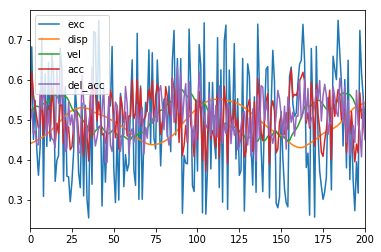

In [69]:
train_df.loc[:200, :].plot()

### Some config params

In [70]:
td_shape = train_df.shape
td_l = td_shape[0]

In [71]:
x_labels = ['exc', 'del_acc']
y_labels = ['acc']

In [72]:
n_input_labels = len(x_labels)
y_offset = 1

In [73]:
train_percentage = 0.7
length_train_data = len(train_df)
split_index = int(length_train_data*train_percentage)

In [74]:
split_index

69930

## Get train and test data

### Walk forward

In [75]:
X_train, X_test, y_train, y_test = walk_forward(train_df, 
                                                x_labels, y_labels, 
                                                n, n_input_labels, y_offset=y_offset,
                                                split_per=0.7, split_data=True)

# X_train = X_train.reshape(-1, n, n_input_labels, 1)
# y_train = y_train.reshape(-1, n-y_offset)

# X_test = train_df[x_labels].iloc[split_index:, :].values.reshape(-1, n, n_input_labels, 1)
# y_test = train_df[y_labels].iloc[split_index:, :].values

# y_test_indices = [range(i+y_offset, i+n) for i in range(0, len(train_df.iloc[split_index:, :])-n+1, n)]
# y_test = y_test[y_test_indices].reshape(-1, n-y_offset)

### Batched sequences

In [76]:
# X_train, X_test, y_train, y_test = batch_sequence_split(train_df, 
#                                                         x_labels, 
#                                                         y_labels, 
#                                                         n, 
#                                                         n_input_labels,
#                                                         split_index)

## Model

In [77]:
tb_callback = TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True)

In [78]:
class Model():

    def __init__(self):
        self.mdl = None
        self.hist = None

    def create_model(self, input_shape, n_outputs):

        # Optimiser
        opt = Adam(lr=0.001)

        # define model
        self.mdl = Sequential()

        self.mdl.add(Conv2D(9, (2,1), input_shape=input_shape))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())

        self.mdl.add(Flatten())
        self.mdl.add(Dense(500, activation='relu'))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())
        
        self.mdl.add(Dense(n_outputs))

        # Prepare model for training
        self.mdl.compile(loss='mae',
                      optimizer=opt,
                      metrics=['mse'])


    def run_model(self, X_train, X_test, y_train, y_test, callback):

        # Fit model
        self.hist = self.mdl.fit(X_train, y_train,
                                batch_size=1000,
                                epochs=100,
                                verbose=True,
                                validation_data=(X_test, y_test),
                                callbacks=[callback])

In [79]:
# Create Model
model = Model()
model.create_model(X_train[0].shape, n-y_offset)

In [80]:
model.mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 99, 2, 9)          27        
_________________________________________________________________
dropout_5 (Dropout)          (None, 99, 2, 9)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 99, 2, 9)          36        
_________________________________________________________________
flatten_3 (Flatten)          (None, 1782)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               891500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 500)               2000      
__________

In [81]:
model.run_model(X_train, X_test, y_train, y_test, tb_callback)

Train on 69860 samples, validate on 29940 samples
Epoch 1/100
69860/69860 [==============================] - 1s 13us/step - loss: 0.6096 - mean_squared_error: 0.6614 - val_loss: 0.2051 - val_mean_squared_error: 0.0661
Epoch 2/100
69860/69860 [==============================] - 1s 8us/step - loss: 0.1523 - mean_squared_error: 0.0430 - val_loss: 0.0712 - val_mean_squared_error: 0.0077
Epoch 3/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0693 - mean_squared_error: 0.0077 - val_loss: 0.0423 - val_mean_squared_error: 0.0028
Epoch 4/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0558 - mean_squared_error: 0.0049 - val_loss: 0.0374 - val_mean_squared_error: 0.0022
Epoch 5/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0491 - mean_squared_error: 0.0038 - val_loss: 0.0344 - val_mean_squared_error: 0.0019
Epoch 6/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0450 - mean_squared_error: 0.0032

69860/69860 [==============================] - 1s 9us/step - loss: 0.0290 - mean_squared_error: 0.0013 - val_loss: 0.0254 - val_mean_squared_error: 0.0010
Epoch 50/100
69860/69860 [==============================] - 1s 8us/step - loss: 0.0289 - mean_squared_error: 0.0013 - val_loss: 0.0257 - val_mean_squared_error: 0.0010
Epoch 51/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0289 - mean_squared_error: 0.0013 - val_loss: 0.0254 - val_mean_squared_error: 0.0010
Epoch 52/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0288 - mean_squared_error: 0.0013 - val_loss: 0.0254 - val_mean_squared_error: 0.0010
Epoch 53/100
69860/69860 [==============================] - 1s 10us/step - loss: 0.0288 - mean_squared_error: 0.0013 - val_loss: 0.0253 - val_mean_squared_error: 0.0010
Epoch 54/100
69860/69860 [==============================] - 1s 11us/step - loss: 0.0287 - mean_squared_error: 0.0013 - val_loss: 0.0253 - val_mean_squared_error: 0.0010
Epo

Epoch 97/100
69860/69860 [==============================] - 1s 9us/step - loss: 0.0270 - mean_squared_error: 0.0012 - val_loss: 0.0240 - val_mean_squared_error: 9.0612e-04
Epoch 98/100
69860/69860 [==============================] - 1s 10us/step - loss: 0.0270 - mean_squared_error: 0.0012 - val_loss: 0.0241 - val_mean_squared_error: 9.1159e-04
Epoch 99/100
69860/69860 [==============================] - 1s 11us/step - loss: 0.0270 - mean_squared_error: 0.0012 - val_loss: 0.0240 - val_mean_squared_error: 9.0365e-04
Epoch 100/100
69860/69860 [==============================] - 1s 10us/step - loss: 0.0270 - mean_squared_error: 0.0012 - val_loss: 0.0240 - val_mean_squared_error: 9.0844e-04


## Evaluation

In [82]:
# Scores
print(model.mdl.evaluate(X_test, y_test, verbose=0))

[0.024036720915185505, 0.0009084432479025237]


                  0
count  2.964060e+06
mean  -9.932855e-06
std    3.014040e-02
min   -1.465945e-01
25%   -2.037389e-02
50%   -1.169635e-04
75%    2.026567e-02
max    1.533409e-01


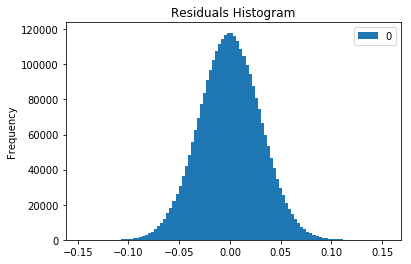

In [83]:
# Error plot (%)
preds = model.mdl.predict(X_test)
resids_all = preds-y_test
resids = pd.DataFrame((preds - y_test).reshape(-1))
resids.plot(kind='hist', bins=100, title='Residuals Histogram')
print(resids.describe())

In [84]:
print(skew(resids)[0])
print(skewtest(resids))

0.019708421391263792
SkewtestResult(statistic=array([13.85092078]), pvalue=array([1.25591758e-43]))


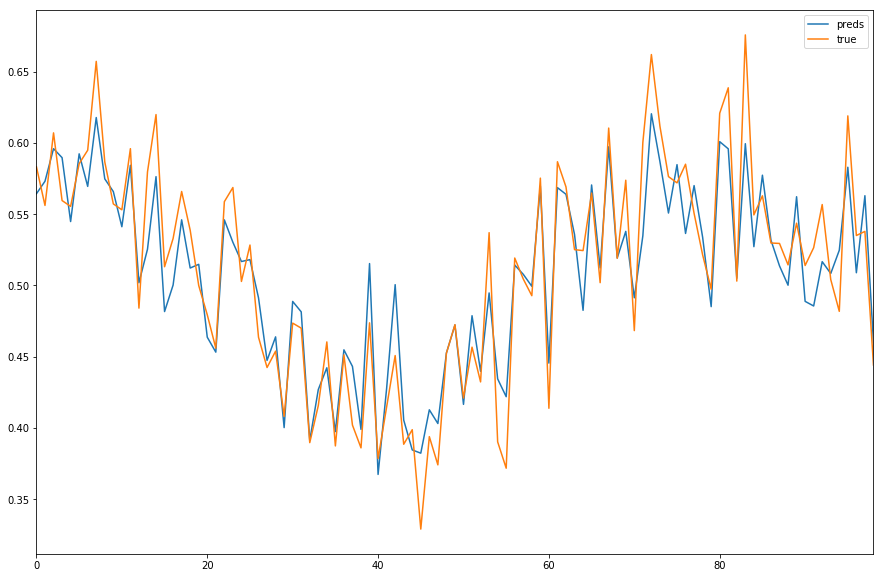

In [85]:
comp_ind = 1000
comparison = pd.concat([pd.DataFrame(preds[comp_ind].reshape(-1), columns=['preds']), 
                        pd.DataFrame(y_test[comp_ind].reshape(-1), columns=['true'])], axis=1)
comparison.plot(figsize=(15,10))

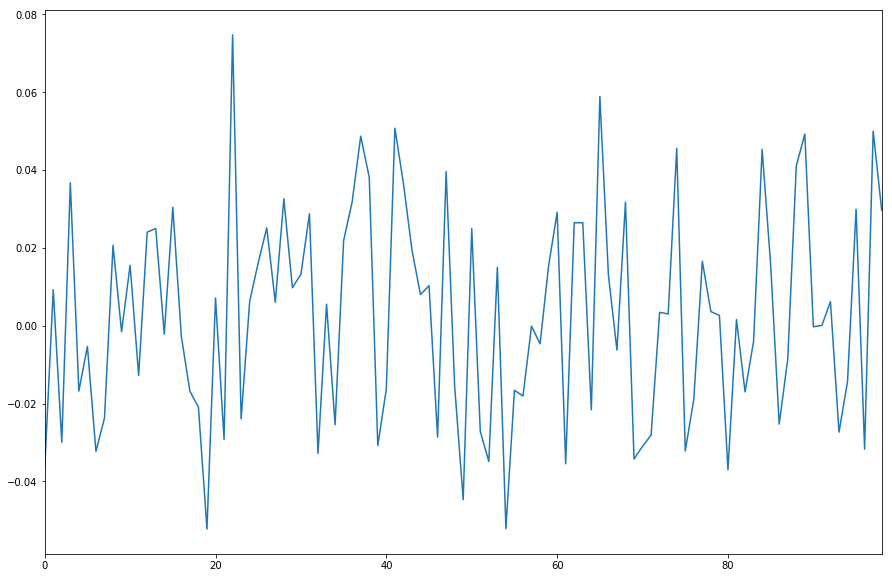

In [86]:
indices = np.random.randint(low=0, high=len(resids_all), size=1)
pd.DataFrame((resids_all[indices])).T.plot(figsize=(15,10), legend=False)

In [87]:
r2_score(y_test, preds)

0.7527096087099883

## Scaled

In [37]:
disp_raw = np.genfromtxt('./data/disp.csv', delimiter=',')

KeyboardInterrupt: 

In [ ]:
disp_df = pd.DataFrame(disp_raw.T, columns=['disp', 'disp_10noise'])['disp_10noise']

In [ ]:
mean = disp_df.mean()
minimum = disp_df.min()
maximum = disp_df.max()

In [ ]:
scaled_resids = pd.DataFrame(((((resids_all -0.5) * 2.0) * (maximum - minimum)) + mean).reshape(-1))

In [ ]:
scaled_resids.mean()

In [ ]:
scaled_resids.plot(kind='hist', bins=100, figsize=(15,10), title='Errors Histogram for SDOF Problem with 10% Noise')
print('Error Standard Deviation: %E' % scaled_resids.std())
print('Error Mean: %E' % scaled_resids.mean())